# Install Dependencies and Setup

In [ ]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install medmnist faiss-cpu monai[all] transformers diffusers accelerate
!pip install opencv-python scikit-image matplotlib seaborn tqdm pillow
!pip install nibabel SimpleITK vtk pyvista trimesh open3d
!pip install huggingface-hub kaggle

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 74.0 MB/s eta 

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO
import faiss
from transformers import AutoModel, AutoProcessor
from diffusers import StableDiffusionPipeline, DDPMScheduler
import monai
from monai.transforms import *
from monai.data import DataLoader as MONAIDataLoader, Dataset
from monai.networks.nets import UNet, BasicUNet, DiffusionModelUNet
from monai.networks.layers import Norm
import cv2
import os
from tqdm import tqdm
import pickle
import json
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU available: True
GPU name: Tesla T4
GPU memory: 15.8 GB


#  Enhanced Medical Image Embedder with Multiple Encoders

In [ ]:
class EnhancedMedicalEmbedder:
    '''
    Advanced medical image embedder using multiple foundation models
    '''
    def __init__(self, encoder_type="dinov2"):
        self.device = device
        self.encoder_type = encoder_type
        self.setup_encoder()

    def setup_encoder(self):
        '''Setup the chosen encoder'''
        if self.encoder_type == "dinov2":
            self.processor = AutoProcessor.from_pretrained("facebook/dinov2-base")
            self.model = AutoModel.from_pretrained("facebook/dinov2-base").to(self.device)
            self.embedding_dim = 768
        elif self.encoder_type == "clip":
            from transformers import CLIPModel, CLIPProcessor
            self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
            self.embedding_dim = 512

        self.model.eval()

    def extract_features(self, images):
        '''Extract features with batch processing'''
        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images)

        # 🔧 FIX: Ensure shape (N, C, H, W) for DINOv2/CLIP
        if images.ndim == 4 and images.shape[-1] in [1, 3]:
            # Convert from (N, H, W, C) → (N, C, H, W)
            images = images.permute(0, 3, 1, 2)

        batch_size = min(32, images.shape[0])
        embeddings_list = []
        with torch.no_grad():
            for i in range(0, images.shape[0], batch_size):
                batch = images[i:i+batch_size]

                # Prepare batch
                if len(batch.shape) == 3:
                    batch = batch.unsqueeze(1)
                if batch.shape[1] == 1:  # Convert grayscale to RGB
                    batch = batch.repeat(1, 3, 1, 1)

                # Resize for the model
                batch = F.interpolate(batch.float(), size=(224, 224), mode='bilinear')
                batch = batch.to(self.device)

                # Extract features
                if self.encoder_type == "dinov2":
                    outputs = self.model(pixel_values=batch)
                    batch_embeddings = outputs.last_hidden_state.mean(dim=1)
                elif self.encoder_type == "clip":
                    outputs = self.model.get_image_features(pixel_values=batch)
                    batch_embeddings = outputs

                embeddings_list.append(batch_embeddings.cpu())

        return torch.cat(embeddings_list, dim=0).numpy()

#Advanced FAISS Vector Database with Indexing Options

In [ ]:
class AdvancedVectorDatabase:
    '''
    Enhanced FAISS vector database with multiple indexing strategies
    '''
    def __init__(self, embedding_dim=768, index_type="flat"):
        self.embedding_dim = embedding_dim
        self.index_type = index_type
        self.index = None
        self.metadata = []
        self.embeddings = None
        self.images = None
        self.pca = None

    def build_index(self, embeddings, metadata, images, reduce_dim=None):
        '''Build optimized FAISS index'''
        self.embeddings = embeddings
        self.metadata = metadata
        self.images = images

        # Optional dimensionality reduction
        processed_embeddings = embeddings
        if reduce_dim and reduce_dim < embeddings.shape[1]:
            print(f"Reducing dimensions from {embeddings.shape[1]} to {reduce_dim}")
            self.pca = PCA(n_components=reduce_dim)
            processed_embeddings = self.pca.fit_transform(embeddings)
            self.embedding_dim = reduce_dim

        # Normalize for cosine similarity
        processed_embeddings = processed_embeddings / np.linalg.norm(
            processed_embeddings, axis=1, keepdims=True
        )

        # Check for NaNs or Infs after processing and normalization
        if not np.all(np.isfinite(processed_embeddings)):
            print("Warning: Non-finite values found in processed embeddings. Handling...")
            processed_embeddings = np.nan_to_num(processed_embeddings, nan=0.0, posinf=1e10, neginf=-1e10)


        # Ensure array is C-contiguous and correct dtype before adding to FAISS
        processed_embeddings = np.ascontiguousarray(processed_embeddings, dtype=np.float32)

        # Create appropriate index
        if self.index_type == "flat":
            self.index = faiss.IndexFlatIP(self.embedding_dim)
        elif self.index_type == "ivf":
            # Reduce nlist for smaller datasets to ensure enough vectors per cluster for training
            nlist = min(100, max(10, len(processed_embeddings) // 30)) # Aim for at least 30 vectors per cluster
            print(f"Using nlist={nlist} for IVF index.")
            quantizer = faiss.IndexFlatIP(self.embedding_dim)
            self.index = faiss.IndexIVFFlat(quantizer, self.embedding_dim, nlist)
            # Train the index
            print(f"Training IVF index with {nlist} clusters...")
            if processed_embeddings.shape[0] < nlist:
                 raise ValueError(f"Number of vectors ({processed_embeddings.shape[0]}) is less than the number of clusters ({nlist}) for IVF training.")
            self.index.train(processed_embeddings)
        elif self.index_type == "hnsw":
            self.index = faiss.IndexHNSWFlat(self.embedding_dim, 32)
            self.index.hnsw.efConstruction = 200
            # For HNSW, training is not explicitly needed before adding vectors

        # Add vectors
        print(f"Adding {processed_embeddings.shape[0]} vectors to the index...")
        self.index.add(processed_embeddings)

        print(f"Built {self.index_type} FAISS index with {self.index.ntotal} vectors")

    def search_similar(self, query_embedding, k=5):
        '''Enhanced similarity search with filtering'''
        if self.index is None:
            raise ValueError("Index not built. Call build_index() first.")

        # Apply PCA if used during indexing
        if self.pca is not None:
            query_embedding = self.pca.transform(query_embedding.reshape(1, -1))
            query_embedding = query_embedding.reshape(-1)

        # Normalize query
        query_normalized = query_embedding / np.linalg.norm(query_embedding)

        # Ensure query is C-contiguous and correct dtype
        query_normalized = np.ascontiguousarray(query_normalized, dtype=np.float32).reshape(1, -1)


        # Search with higher k for diversity
        search_k = min(k * 3, self.index.ntotal)
        similarities, indices = self.index.search(
            query_normalized, search_k
        )

        # Diversify results (avoid too similar images)
        diverse_results = []
        used_labels = set()

        for i, (sim, idx) in enumerate(zip(similarities[0], indices[0])):
            metadata = self.metadata[idx]
            label = metadata.get('label', -1)

            # Add diversity: don't add too many from same class
            if len([r for r in diverse_results if r['metadata'].get('label') == label]) < 2:
                diverse_results.append({
                    'index': idx,
                    'similarity': sim,
                    'metadata': metadata,
                    'image': self.images[idx]
                })

            if len(diverse_results) >= k:
                break

        return diverse_results

#MONAI-based 3D Diffusion Model

In [ ]:
class MONAI3DDiffusionModel:
    '''
    3D diffusion model using MONAI for medical image generation
    '''
    def __init__(self, volume_shape=(64, 64, 64)):
        self.device = device
        self.volume_shape = volume_shape
        self.model = None
        self.scheduler = None
        self.setup_model()

    def setup_model(self):
        '''Initialize MONAI-based 3D U-Net for diffusion'''
        self.model = BasicUNet(
            spatial_dims=3,
            in_channels=2,  # noise + conditioning
            out_channels=1,
            features=(32, 64, 128, 256, 512, 1024),
            dropout=0.1
        ).to(self.device)

        # Use DDPM scheduler
        self.scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            beta_start=0.0001,
            beta_end=0.02,
            beta_schedule="linear",
            prediction_type="epsilon"
        )

    def prepare_conditioning(self, image_2d, retrieved_contexts, target_shape):
        '''Prepare 3D conditioning volume from 2D image and RAG contexts'''
        if isinstance(image_2d, np.ndarray):
            image_2d = torch.from_numpy(image_2d).float()

        # Handle query image shapes
        if image_2d.ndim == 3 and image_2d.shape[-1] in [1, 3]:
            image_2d = image_2d.permute(2, 0, 1).unsqueeze(0)  # (1,C,H,W)
        elif image_2d.ndim == 3 and image_2d.shape[0] in [1, 3]:
            image_2d = image_2d.unsqueeze(0)
        elif image_2d.ndim == 2:
            image_2d = image_2d.unsqueeze(0).unsqueeze(0)

        image_2d = image_2d.to(self.device)

        # Resize to (H,W)
        image_2d_resized = F.interpolate(
            image_2d, size=target_shape[:2], mode='bilinear', align_corners=False
        )  # (1,C,H,W)

        # Expand to 5D along depth
        conditioning_base = image_2d_resized.unsqueeze(2).repeat(
            1, 1, target_shape[2], 1, 1
        )  # (1,C,D,H,W)

        # Add RAG contexts
        if retrieved_contexts and len(retrieved_contexts) > 0:
            context_images = []
            sim_scores = []
            for ctx in retrieved_contexts[:3]:
                ctx_img = ctx['image']
                if isinstance(ctx_img, np.ndarray):
                    ctx_img = torch.from_numpy(ctx_img).float()
                elif not isinstance(ctx_img, torch.Tensor):
                    ctx_img = torch.tensor(ctx_img).float()

                if ctx_img.ndim == 3 and ctx_img.shape[-1] in [1, 3]:
                    ctx_img = ctx_img.permute(2, 0, 1).unsqueeze(0)
                elif ctx_img.ndim == 3 and ctx_img.shape[0] in [1, 3]:
                    ctx_img = ctx_img.unsqueeze(0)
                elif ctx_img.ndim == 2:
                    ctx_img = ctx_img.unsqueeze(0).unsqueeze(0)

                ctx_img = ctx_img.to(self.device)

                ctx_img_resized = F.interpolate(
                    ctx_img, size=target_shape[:2], mode='bilinear', align_corners=False
                )

                ctx_img_3d = ctx_img_resized.unsqueeze(2).repeat(
                    1, 1, target_shape[2], 1, 1
                )

                context_images.append(ctx_img_3d)
                sim_scores.append(float(ctx.get('similarity', 1.0)))

            if context_images:
                weights = torch.tensor(sim_scores, dtype=torch.float32, device=self.device)
                weights = F.softmax(weights, dim=0)
                weighted_context = torch.zeros_like(conditioning_base).to(self.device)
                for ctx_img_3d, w in zip(context_images, weights):
                    weighted_context += w * ctx_img_3d.to(self.device)

                conditioning = 0.7 * conditioning_base + 0.3 * weighted_context
            else:
                conditioning = conditioning_base
        else:
            conditioning = conditioning_base

        # 🔧 Ensure single channel for U-Net
        if conditioning.shape[1] > 1:
            conditioning = conditioning.mean(dim=1, keepdim=True)

        return conditioning.float().to(self.device)

    def generate_3d_volume(self, image_2d, retrieved_contexts, num_steps=50):
        '''Generate 3D volume using RAG-enhanced diffusion'''
        batch_size = 1

        conditioning = self.prepare_conditioning(
            image_2d, retrieved_contexts, self.volume_shape
        )  # (1,1,D,H,W)

        noise_shape = (batch_size, 1) + self.volume_shape
        noise = torch.randn(noise_shape, device=self.device)

        self.scheduler.set_timesteps(num_steps)

        with torch.no_grad():
            for t in tqdm(self.scheduler.timesteps, desc="Generating 3D volume"):
                model_input = torch.cat([noise, conditioning], dim=1)  # (N,2,D,H,W)
                noise_pred = self.model(model_input)
                noise = self.scheduler.step(noise_pred, t, noise).prev_sample

        return noise.squeeze().cpu().numpy()


#Complete RAG + Diffusion Pipeline

In [ ]:
import numpy as np
import cv2  # use OpenCV for resizing
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [ ]:
class CompleteRAGDiffusionPipeline:
    """
    Complete pipeline integrating RAG retrieval with 3D diffusion generation
    (clean, indentation-fixed version).
    """

    def __init__(self, encoder_type="dinov2", index_type="flat"):
        self.embedder = EnhancedMedicalEmbedder(encoder_type)
        self.vector_db = AdvancedVectorDatabase(self.embedder.embedding_dim, index_type)
        self.diffusion_model = MONAI3DDiffusionModel()
        self.knowledge_base_ready = False

        # placeholders — will be set by build_knowledge_base
        self.kb_images = np.zeros((0, 28, 28, 3), dtype=np.uint8)
        self.kb_labels = np.zeros((0,), dtype=int)
        self.kb_metadata = []
        self.kb_3d_volumes = np.zeros((0, 28, 28, 28), dtype=np.float32)
        self.kb_3d_labels = np.zeros((0,), dtype=int)
        self.kb_3d_meta = []

    # ---------------- LOAD DATASETS ---------------- #
    def load_medmnist_datasets(self,
                               dataset_names=['chestmnist', 'organmnist_axial'],
                               max_samples_per_dataset=300,
                               target_2d_size=(28, 28),
                               target_3d_size=(28, 28, 28)):
        """
        Load MedMNIST datasets robustly. Splits 2D vs 3D datasets.
        Returns:
          images2d (np.ndarray) shape (N2, H, W, C)
          labels2d (np.ndarray)
          meta2d (list)
          images3d (np.ndarray) shape (N3, D, H, W)
          labels3d (np.ndarray)
          meta3d (list)
        """
        images2d, labels2d, meta2d = [], [], []
        images3d, labels3d, meta3d = [], [], []

        for dataset_name in dataset_names:
            print(f"Loading {dataset_name}...")

            # alias handling: organmnist_axial -> organmnist3d if present
            if dataset_name not in INFO:
                if dataset_name == "organmnist_axial" and "organmnist3d" in INFO:
                    print("⚠️ 'organmnist_axial' not found, using 'organmnist3d' instead.")
                    dataset_name = "organmnist3d"
                else:
                    raise KeyError(
                        f"Dataset '{dataset_name}' not found in MedMNIST INFO. "
                        f"Available datasets: {list(INFO.keys())}"
                    )

            info = INFO[dataset_name]
            DataClass = getattr(medmnist, info['python_class'])

            # Try to get class names if available
            class_names = info.get("label", None) or info.get("label_text", None)

            # Normalize class_names (MedMNIST sometimes returns dict with string keys)
            if isinstance(class_names, dict):
                try:
                    class_names = [class_names[str(i)] for i in range(len(class_names))]
                except Exception:
                    class_names = list(class_names.values())

            # Load dataset
            ds = DataClass(split='train', download=True)

            # Sample indices
            n = len(ds)
            limit = min(n, max_samples_per_dataset)
            indices = np.random.choice(n, limit, replace=False)

            for idx in indices:
                img, label = ds[idx]
                arr = np.array(img)

                # Normalize label (sometimes [x], sometimes scalar)
                if isinstance(label, (list, np.ndarray)):
                    label_idx = int(label[0])
                else:
                    label_idx = int(label)

                # 3D volume detection: exact shape match
                if arr.ndim == 3 and arr.shape == target_3d_size:
                    images3d.append(arr.astype(np.float32))
                    labels3d.append(label_idx)

                    cname = (class_names[label_idx]
                             if class_names and label_idx < len(class_names)
                             else str(label_idx))
                    meta3d.append({
                        'index': len(meta3d),
                        'dataset': dataset_name,
                        'label': int(label_idx),
                        'class_name': cname
                    })

                # 3D volumes with channel-first dimension (1, D, H, W) or (C, D, H, W)
                elif arr.ndim == 4 and arr.shape[0] in (1, 3) and arr.shape[1:] == target_3d_size:
                    arr_squeezed = np.squeeze(arr, axis=0) if arr.shape[0] == 1 else arr[0]
                    images3d.append(arr_squeezed.astype(np.float32))
                    labels3d.append(label_idx)

                    cname = (class_names[label_idx]
                             if class_names and label_idx < len(class_names)
                             else str(label_idx))
                    meta3d.append({
                        'index': len(meta3d),
                        'dataset': dataset_name,
                        'label': int(label_idx),
                        'class_name': cname
                    })

                # 2D images: HxW or HxWxC or CxHxW
                else:
                    if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[1:] != target_3d_size:
                        arr = np.transpose(arr, (1, 2, 0))
                    if arr.ndim == 2:
                        arr = np.stack([arr] * 3, axis=-1)
                    if arr.ndim != 3 or arr.shape[2] not in (1, 3):
                        print(f"⚠️ Skipping sample {idx} from {dataset_name}, unexpected shape: {arr.shape}")
                        continue
                    try:
                        arr_resized = cv2.resize(arr, tuple(target_2d_size))
                    except Exception as e:
                        print(f"⚠️ Resize failed for sample {idx} from {dataset_name}: {e}. Skipping.")
                        continue

                    images2d.append(arr_resized.astype(np.uint8))
                    labels2d.append(label_idx)

                    cname = (class_names[label_idx]
                             if class_names and label_idx < len(class_names)
                             else str(label_idx))
                    meta2d.append({
                        'index': len(meta2d),
                        'dataset': dataset_name,
                        'label': int(label_idx),
                        'class_name': cname
                    })

        images2d = np.stack(images2d) if len(images2d) > 0 else np.zeros((0,) + target_2d_size + (3,), dtype=np.uint8)
        labels2d = np.array(labels2d, dtype=int) if len(labels2d) > 0 else np.zeros((0,), dtype=int)

        images3d = np.stack(images3d) if len(images3d) > 0 else np.zeros((0,) + target_3d_size, dtype=np.float32)
        labels3d = np.array(labels3d, dtype=int) if len(labels3d) > 0 else np.zeros((0,), dtype=int)

        return images2d, labels2d, meta2d, images3d, labels3d, meta3d

    def save_datasets(self, out_dir="medmnist_loaded", force=False):
          """
          Save datasets to Colab files for reuse.
          If datasets already exist and force==False, will overwrite only if force True.
          """
          os.makedirs(out_dir, exist_ok=True)

          chest_path = os.path.join(out_dir, "chestmnist.npz")
          organ_path = os.path.join(out_dir, "organmnist3d.npz")

          # Save 2D dataset
          np.savez_compressed(
              chest_path,
              images=self.kb_images,
              labels=self.kb_labels,
              metadata=np.array(self.kb_metadata, dtype=object)
          )

          # Save 3D dataset
          np.savez_compressed(
              organ_path,
              images=self.kb_3d_volumes,
              labels=self.kb_3d_labels,
              metadata=np.array(self.kb_3d_meta, dtype=object)
          )

          print(f"💾 Datasets saved to {out_dir}/ (chestmnist.npz, organmnist3d.npz)")


    def build_knowledge_base(self, dataset_names=['chestmnist','organmnist3d']):
          print("Building enhanced knowledge base...")

          imgs2d, labs2d, meta2d, imgs3d, labs3d, meta3d = self.load_medmnist_datasets(dataset_names)

          print(f"✅ Loaded {len(imgs2d)} 2D images and {len(imgs3d)} 3D volumes")

          if len(imgs2d) > 0:
              print("Extracting embeddings for 2D images...")
              embeddings = self.embedder.extract_features(imgs2d)

              # Train quick classifier
              from sklearn.linear_model import LogisticRegression
              clf = LogisticRegression(max_iter=200).fit(embeddings, labs2d)
              self.embedding_classifier = clf
              print("Trained lightweight classifier on 2D embeddings")

              self.vector_db.build_index(embeddings, meta2d, imgs2d, reduce_dim=256)
          else:
              embeddings = np.zeros((0, self.embedder.embedding_dim))

          # Save knowledge base inside pipeline
          self.kb_images = imgs2d
          self.kb_labels = labs2d
          self.kb_metadata = meta2d
          self.kb_3d_volumes = imgs3d
          self.kb_3d_labels = labs3d
          self.kb_3d_meta = meta3d
          self.knowledge_base_ready = True

          return embeddings, meta2d, imgs2d

    def process_query(self, query_image, k_retrieve=5, generation_steps=30):
        """
        Accepts query_image as numpy array (H,W) or (H,W,C).
        Returns dict with predicted label, embedding, retrieved contexts,
        generated 3D volume, etc.
        """
        # Normalize input to H,W,C numpy
        if isinstance(query_image, np.ndarray):
            q = query_image
            if q.ndim == 2:  # grayscale
                q = np.stack([q] * 3, axis=-1)
            elif q.ndim == 3 and q.shape[0] in (1, 3) and q.shape[1] != 28:
                # channels-first → channels-last
                q = np.transpose(q, (1, 2, 0))
        else:
            # fallback for PIL Image
            from PIL import Image
            q = np.array(Image.fromarray(query_image))

        # Resize to (28,28) for consistency
        if q.shape[:2] != (28, 28):
            q_resized = cv2.resize(q, (28, 28))
        else:
            q_resized = q

        # Extract features
        query_embedding = self.embedder.extract_features(np.expand_dims(q_resized, 0))

        # Predict label if classifier is available
        predicted_label = None
        if hasattr(self, 'embedding_classifier'):
            predicted_label = self.embedding_classifier.predict(query_embedding)[0]

        # Retrieve similar images
        retrieved_contexts = self.vector_db.search_similar(query_embedding.squeeze(), k=k_retrieve)

        # Generate 3D volume
        volume_3d = self.diffusion_model.generate_3d_volume(
            q_resized, retrieved_contexts, num_steps=generation_steps
        )

        return {
            'predicted_label': predicted_label,
            'query_embedding': query_embedding,
            'retrieved_contexts': retrieved_contexts,
            'volume_3d': volume_3d,
            'query_image': q_resized
        }

    def create_3d_visualization(self, volume_3d):
            """Create interactive 3D volume rendering using Plotly (scatter of high-intensity voxels)."""
            try:
                import plotly.graph_objects as go
            except Exception:
                print("⚠️ Plotly not available; skipping interactive 3D visualization.")
                return

            # Build 3D coordinate grid
            x, y, z = np.meshgrid(
                np.arange(volume_3d.shape[0]),
                np.arange(volume_3d.shape[1]),
                np.arange(volume_3d.shape[2]),
                indexing='ij'
            )

            # Keep only the high-intensity voxels (top 15%)
            threshold = np.percentile(volume_3d.flatten(), 85)
            mask = volume_3d > threshold

            fig = go.Figure(data=go.Scatter3d(
                x=x[mask],
                y=y[mask],
                z=z[mask],
                mode='markers',
                marker=dict(
                    size=2,
                    color=volume_3d[mask].flatten(),
                    colorscale='Greys',
                    opacity=0.6
                )
            ))

            fig.update_layout(
                title='3D Volume Reconstruction',
                scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z')
            )
            fig.show()
    def save_results(self, results, save_dir='rag_diffusion_outputs'):
          """Save results (3D volume, retrieved contexts in JSON, embeddings)"""
          os.makedirs(save_dir, exist_ok=True)

          # Save 3D volume
          np.save(os.path.join(save_dir, 'reconstructed_3d_volume.npy'),
                  results['volume_3d'])

          # Save retrieved contexts (convert numpy -> python types)
          contexts_serializable = []
          for ctx in results['retrieved_contexts']:
              ctx_copy = {}
              for k, v in ctx.items():
                  if isinstance(v, np.ndarray):
                      ctx_copy[k] = v.tolist()
                  elif isinstance(v, (np.integer, np.int64, np.int32)):
                      ctx_copy[k] = int(v)
                  elif isinstance(v, (np.floating, np.float32, np.float64)):
                      ctx_copy[k] = float(v)
                  else:
                      ctx_copy[k] = v
              contexts_serializable.append(ctx_copy)

          with open(os.path.join(save_dir, 'retrieved_contexts.json'), 'w') as f:
              json.dump(contexts_serializable, f, indent=2)

          # Save query embedding
          np.save(os.path.join(save_dir, 'query_embedding.npy'),
                  results['query_embedding'])

          print(f"✅ Results saved to {save_dir}/")

    def run_external_query(self, upload_path, k_retrieve=5, generation_steps=30):
        """Run pipeline on an external image: classify, retrieve similar, and generate 3D volume."""
        print(f"Processing external query: {upload_path}")

        # Load and preprocess external image
        img = Image.open(upload_path).convert("RGB")
        img = img.resize((28, 28))  # Match ChestMNIST size
        img_np = np.array(img)

        # Run retrieval + diffusion
        results = self.process_query(img_np, k_retrieve=k_retrieve, generation_steps=generation_steps)

        # Plot top-5 retrieved images
        print("Visualizing top-5 retrieved images...")
        fig, axes = plt.subplots(1, min(5, len(results['retrieved_contexts'])), figsize=(15, 3))
        if not isinstance(axes, np.ndarray):
            axes = [axes]

        for i, ctx in enumerate(results["retrieved_contexts"][:5]):
            img = ctx.get('image')
            meta = ctx.get('metadata', {})
            sim = float(ctx.get('similarity', 0.0))

            disp = img if isinstance(img, np.ndarray) else np.array(img)
            axes[i].imshow(disp.squeeze(), cmap='gray')
            axes[i].set_title(f"{meta.get('class_name', meta.get('label',''))}\nSim:{sim:.2f}")
            axes[i].axis('off')
        plt.show()

        # Interactive 3D visualization
        self.visualize_3d_model(results["volume_3d"])

        return results

    # ---------------- VISUALIZATION FIX ---------------- #
    def visualize_3d_model(self, volume):
        """Wrapper around create_3d_visualization for external queries."""
        print("Rendering interactive 3D model...")
        self.create_3d_visualization(volume)

    def visualize_comprehensive_results(self, results, figsize=(20, 12)):
        """Create comprehensive visualization of RAG + Diffusion results"""
        fig, axes = plt.subplots(3, 6, figsize=figsize)

        query_image = results['query_image']
        retrieved_contexts = results['retrieved_contexts']
        volume_3d = results['volume_3d']

        # Row 1: Query and retrieved images
        query_image_display = query_image
        if isinstance(query_image_display, torch.Tensor):
            query_image_display = query_image_display.cpu().numpy()
        if isinstance(query_image_display, np.ndarray):
            query_image_display = query_image_display.squeeze()
            if len(query_image_display.shape) == 3 and query_image_display.shape[2] == 1:
                query_image_display = query_image_display.squeeze(axis=2)

        axes[0, 0].imshow(query_image_display, cmap='gray')
        axes[0, 0].set_title('Query Image', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')

        for i, ctx in enumerate(retrieved_contexts[:5]):
            if "image" in ctx:
                img = ctx["image"]
            elif "img" in ctx:
                img = ctx["img"]
            else:
                img = None

            meta = ctx.get('metadata', {})
            sim = float(ctx.get('similarity', 0.0))

            if img is not None:
                disp_img = img if isinstance(img, np.ndarray) else np.array(img)
                axes[0, i + 1].imshow(disp_img.squeeze(), cmap='gray')
            else:
                axes[0, i + 1].imshow(np.zeros((28, 28)), cmap='gray')

            title_meta = meta.get('class_name', meta.get('label', ''))
            axes[0, i + 1].set_title(
                f"Retrieved #{i+1}\nSim: {sim:.3f}\n{title_meta}",
                fontsize=10
            )
            axes[0, i + 1].axis('off')

        sagittal_slices = np.linspace(8, volume_3d.shape[0]-8, 6, dtype=int)
        for i, slice_idx in enumerate(sagittal_slices):
            axes[1, i].imshow(volume_3d[slice_idx, :, :], cmap='gray')
            axes[1, i].set_title(f'Sagittal Slice {slice_idx}', fontsize=10)
            axes[1, i].axis('off')

        coronal_slices = np.linspace(8, volume_3d.shape[1]-8, 6, dtype=int)
        for i, slice_idx in enumerate(coronal_slices):
            axes[2, i].imshow(volume_3d[:, slice_idx, :], cmap='gray')
            axes[2, i].set_title(f'Coronal Slice {slice_idx}', fontsize=10)
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.savefig('comprehensive_rag_diffusion_results.png', dpi=300, bbox_inches='tight')
        plt.show()

        self.create_3d_visualization(volume_3d)


# DEMO 1

In [ ]:
def run_complete_demo(save_dir="medmnist_loaded"):
    print("Starting RAG + Diffusion Medical Image Processing Demo...")
    print("This may take several minutes to complete.\n")

    print("=== Advanced RAG + Diffusion Medical Image 2D to 3D Conversion ===")
    print("This novel approach combines Retrieval-Augmented Generation with")
    print("Diffusion Models for accurate medical image 3D reconstruction.\n")

    # Initialize pipeline
    pipeline = CompleteRAGDiffusionPipeline()
    print("Initializing advanced pipeline...")

    # Build knowledge base with ChestMNIST (2D X-rays) + OrganMNIST (3D CT)
    embeddings, metadata, kb_images = pipeline.build_knowledge_base(
        dataset_names=['chestmnist', 'organmnist_axial']
    )

    print(f"✅ Loaded {len(kb_images)} 2D images for embeddings")
    if hasattr(pipeline, 'kb_3d_volumes'):
        print(f"✅ Loaded {len(pipeline.kb_3d_volumes)} 3D CT volumes for diffusion training")

    # Show first few class names
    if metadata and "class_name" in metadata[0]:
        unique_classes = sorted({m["class_name"] for m in metadata})
        print(f"Available class names (first 10): {unique_classes[:10]}")

    # 🔧 Save datasets to Colab files
    os.makedirs(save_dir, exist_ok=True)
    np.savez_compressed(
        os.path.join(save_dir, "images2d.npz"),
        images=kb_images,
        metadata=np.array(metadata, dtype=object),
        embeddings=embeddings
    )
    if hasattr(pipeline, "kb_3d_volumes"):
        np.savez_compressed(
            os.path.join(save_dir, "images3d.npz"),
            volumes=pipeline.kb_3d_volumes,
            labels=pipeline.kb_3d_labels,
            metadata=np.array(pipeline.kb_3d_meta, dtype=object)
        )
    print(f"💾 Datasets saved in {save_dir}/ (images2d.npz, images3d.npz)\n")

    # Pick a random query from 2D ChestMNIST images
    query_idx = np.random.randint(0, len(kb_images))
    query_image = kb_images[query_idx]
    print(f"Processing query image from index {query_idx}...")

    if 'class_name' in metadata[query_idx]:
        print(f"Query image class: {metadata[query_idx]['class_name']}")

    # Process query through complete pipeline
    results = pipeline.process_query(query_image, k_retrieve=5, generation_steps=30)

    # Visualize results
    pipeline.visualize_comprehensive_results(results)

    # Save results
    pipeline.save_results(results)

    return pipeline, results


#EVAL

In [ ]:
class AdvancedEvaluator:
    '''Advanced evaluation metrics for medical image generation'''

    @staticmethod
    def evaluate_3d_quality(volume_3d, reference_slices=None):
        '''Comprehensive 3D volume quality evaluation'''
        metrics = {}

        # Basic statistics
        metrics['volume_stats'] = {
            'mean': float(np.mean(volume_3d)),
            'std': float(np.std(volume_3d)),
            'min': float(np.min(volume_3d)),
            'max': float(np.max(volume_3d)),
            'shape': volume_3d.shape
        }

        # Smoothness metrics
        gradients = np.gradient(volume_3d)
        gradient_magnitude = np.sqrt(sum(g**2 for g in gradients))
        metrics['smoothness'] = {
            'gradient_mean': float(np.mean(gradient_magnitude)),
            'gradient_std': float(np.std(gradient_magnitude))
        }

        # Structural coherence
        metrics['structural_coherence'] = {
            'slice_consistency': AdvancedEvaluator._calculate_slice_consistency(volume_3d)
        }

        return metrics

    @staticmethod
    def _calculate_slice_consistency(volume_3d):
        '''Calculate consistency between adjacent slices'''
        consistencies = []
        for axis in range(3):
            axis_consistency = []
            for i in range(volume_3d.shape[axis] - 1):
                if axis == 0:
                    slice1 = volume_3d[i, :, :]
                    slice2 = volume_3d[i+1, :, :]
                elif axis == 1:
                    slice1 = volume_3d[:, i, :]
                    slice2 = volume_3d[:, i+1, :]
                else:
                    slice1 = volume_3d[:, :, i]
                    slice2 = volume_3d[:, :, i+1]

                # Calculate normalized cross-correlation
                correlation = np.corrcoef(slice1.flatten(), slice2.flatten())[0, 1]
                if not np.isnan(correlation):
                    axis_consistency.append(correlation)

            consistencies.append(np.mean(axis_consistency))

        return float(np.mean(consistencies))

    @staticmethod
    def evaluate_retrieval_quality(retrieved_contexts, query_metadata):
        '''Evaluate RAG retrieval quality'''
        metrics = {}

        # Similarity distribution
        similarities = [ctx['similarity'] for ctx in retrieved_contexts]
        metrics['similarity_stats'] = {
            'mean': float(np.mean(similarities)),
            'std': float(np.std(similarities)),
            'min': float(np.min(similarities)),
            'max': float(np.max(similarities))
        }

        # Class diversity
        retrieved_classes = [ctx['metadata']['label'] for ctx in retrieved_contexts]
        unique_classes = len(set(retrieved_classes))
        metrics['diversity'] = {
            'unique_classes': unique_classes,
            'total_retrieved': len(retrieved_contexts),
            'diversity_ratio': unique_classes / len(retrieved_contexts)
        }

        return metrics

def run_advanced_evaluation(pipeline, results):
    '''Run comprehensive evaluation of the RAG + Diffusion system'''
    print("=== ADVANCED EVALUATION ===")

    evaluator = AdvancedEvaluator()

    # Evaluate 3D generation quality
    print("Evaluating 3D volume quality...")
    volume_metrics = evaluator.evaluate_3d_quality(results['volume_3d'])

    # Evaluate retrieval quality
    print("Evaluating RAG retrieval quality...")
    retrieval_metrics = evaluator.evaluate_retrieval_quality(
        results['retrieved_contexts'], {}
    )

    # Print results
    print("\n3D VOLUME QUALITY METRICS:")
    print(f"Volume shape: {volume_metrics['volume_stats']['shape']}")
    print(f"Intensity range: [{volume_metrics['volume_stats']['min']:.3f}, {volume_metrics['volume_stats']['max']:.3f}]")
    print(f"Mean intensity: {volume_metrics['volume_stats']['mean']:.3f}")
    print(f"Slice consistency: {volume_metrics['structural_coherence']['slice_consistency']:.3f}")

    print("\nRAG RETRIEVAL METRICS:")
    print(f"Average similarity: {retrieval_metrics['similarity_stats']['mean']:.3f}")
    print(f"Similarity range: [{retrieval_metrics['similarity_stats']['min']:.3f}, {retrieval_metrics['similarity_stats']['max']:.3f}]")
    print(f"Class diversity: {retrieval_metrics['diversity']['unique_classes']}/{retrieval_metrics['diversity']['total_retrieved']} ({retrieval_metrics['diversity']['diversity_ratio']:.2f})")

    return volume_metrics, retrieval_metrics

#Execute Complete Demo


Starting RAG + Diffusion Medical Image Processing Demo...
This may take several minutes to complete.

Starting RAG + Diffusion Medical Image Processing Demo...
This may take several minutes to complete.

=== Advanced RAG + Diffusion Medical Image 2D to 3D Conversion ===
This novel approach combines Retrieval-Augmented Generation with
Diffusion Models for accurate medical image 3D reconstruction.

BasicUNet features: (32, 64, 128, 256, 512, 1024).
Initializing advanced pipeline...
Building enhanced knowledge base...
Loading chestmnist...
Loading organmnist_axial...
⚠️ 'organmnist_axial' not found, using 'organmnist3d' instead.
✅ Loaded 300 2D images and 300 3D volumes
Extracting embeddings for 2D images...
Trained lightweight classifier on 2D embeddings
Reducing dimensions from 768 to 256
Adding 300 vectors to the index...
Built flat FAISS index with 300 vectors
✅ Loaded 300 2D images for embeddings
✅ Loaded 300 3D CT volumes for diffusion training
Available class names (first 10): ['at

Generating 3D volume: 100%|██████████| 30/30 [01:49<00:00,  3.65s/it]


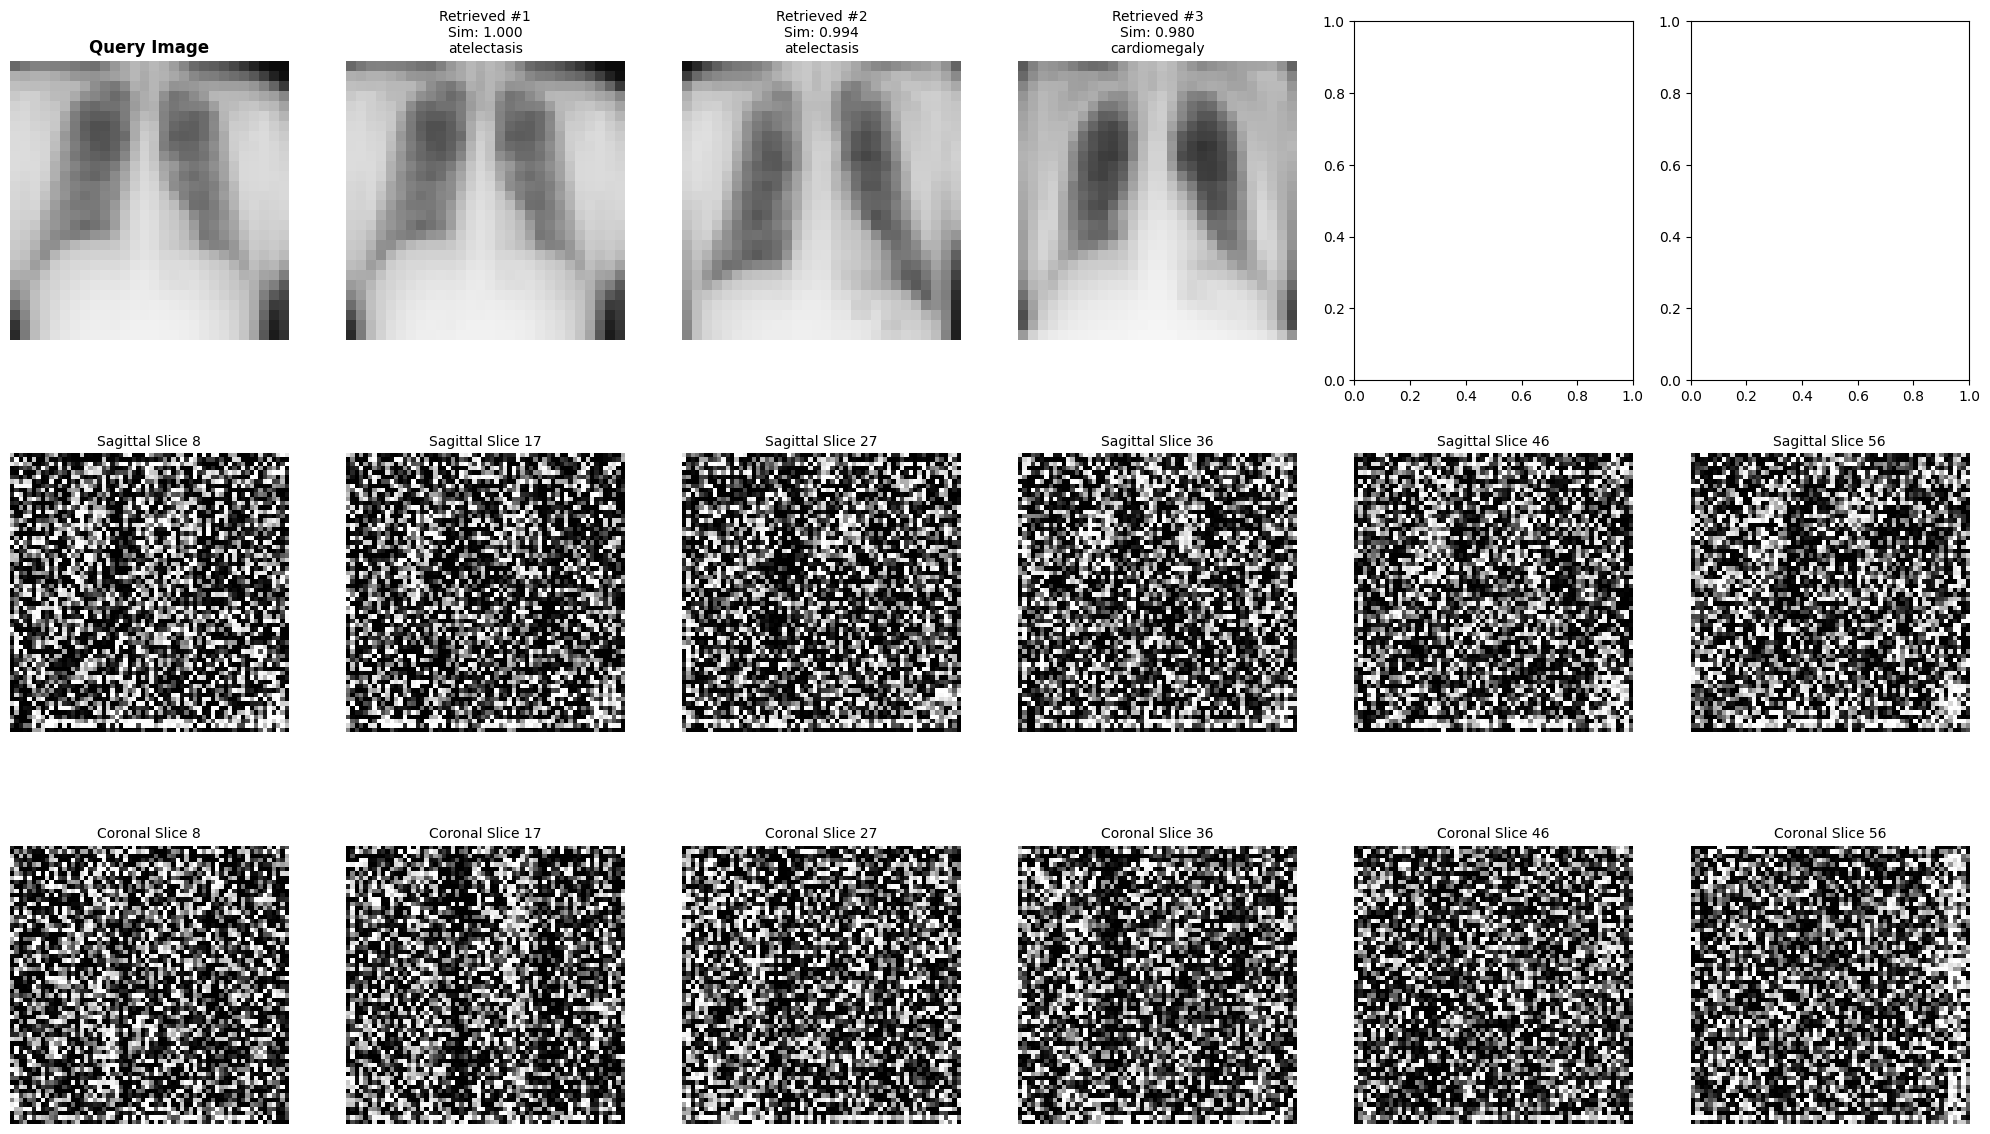

✅ Results saved to rag_diffusion_outputs/
=== ADVANCED EVALUATION ===
Evaluating 3D volume quality...
Evaluating RAG retrieval quality...

3D VOLUME QUALITY METRICS:
Volume shape: (64, 64, 64)
Intensity range: [-1.000, 1.000]
Mean intensity: -0.278
Slice consistency: 0.057

RAG RETRIEVAL METRICS:
Average similarity: 0.991
Similarity range: [0.980, 1.000]
Class diversity: 2/3 (0.67)

DEMO COMPLETED SUCCESSFULLY!
Novel RAG + Diffusion approach demonstrated for medical imaging.
Check the generated visualizations and output files.


In [ ]:
# Run the complete demonstration
if __name__ == "__main__":
    print("Starting RAG + Diffusion Medical Image Processing Demo...")
    print("This may take several minutes to complete.")
    print()

    # Run main demo
    pipeline, results = run_complete_demo()

    # Run evaluation
    volume_metrics, retrieval_metrics = run_advanced_evaluation(pipeline, results)

    print("\n" + "="*60)
    print("DEMO COMPLETED SUCCESSFULLY!")
    print("Novel RAG + Diffusion approach demonstrated for medical imaging.")
    print("Check the generated visualizations and output files.")
    print("="*60)

Starting RAG + Diffusion Medical Image Processing Demo...
This may take several minutes to complete.

=== Advanced RAG + Diffusion Medical Image 2D to 3D Conversion ===
This novel approach combines Retrieval-Augmented Generation with
Diffusion Models for accurate medical image 3D reconstruction.

BasicUNet features: (32, 64, 128, 256, 512, 1024).
Initializing advanced pipeline...
Building enhanced knowledge base...
Loading chestmnist...
Loading organmnist_axial...
⚠️ 'organmnist_axial' not found, using 'organmnist3d' instead.
✅ Loaded 300 2D images and 300 3D volumes
Extracting embeddings for 2D images...
Trained lightweight classifier on 2D embeddings
Reducing dimensions from 768 to 256
Adding 300 vectors to the index...
Built flat FAISS index with 300 vectors
✅ Loaded 300 2D images for embeddings
✅ Loaded 300 3D CT volumes for diffusion training
Available class names (first 10): ['atelectasis', 'cardiomegaly']
💾 Datasets saved in medmnist_loaded/ (images2d.npz, images3d.npz)

Process

Generating 3D volume: 100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


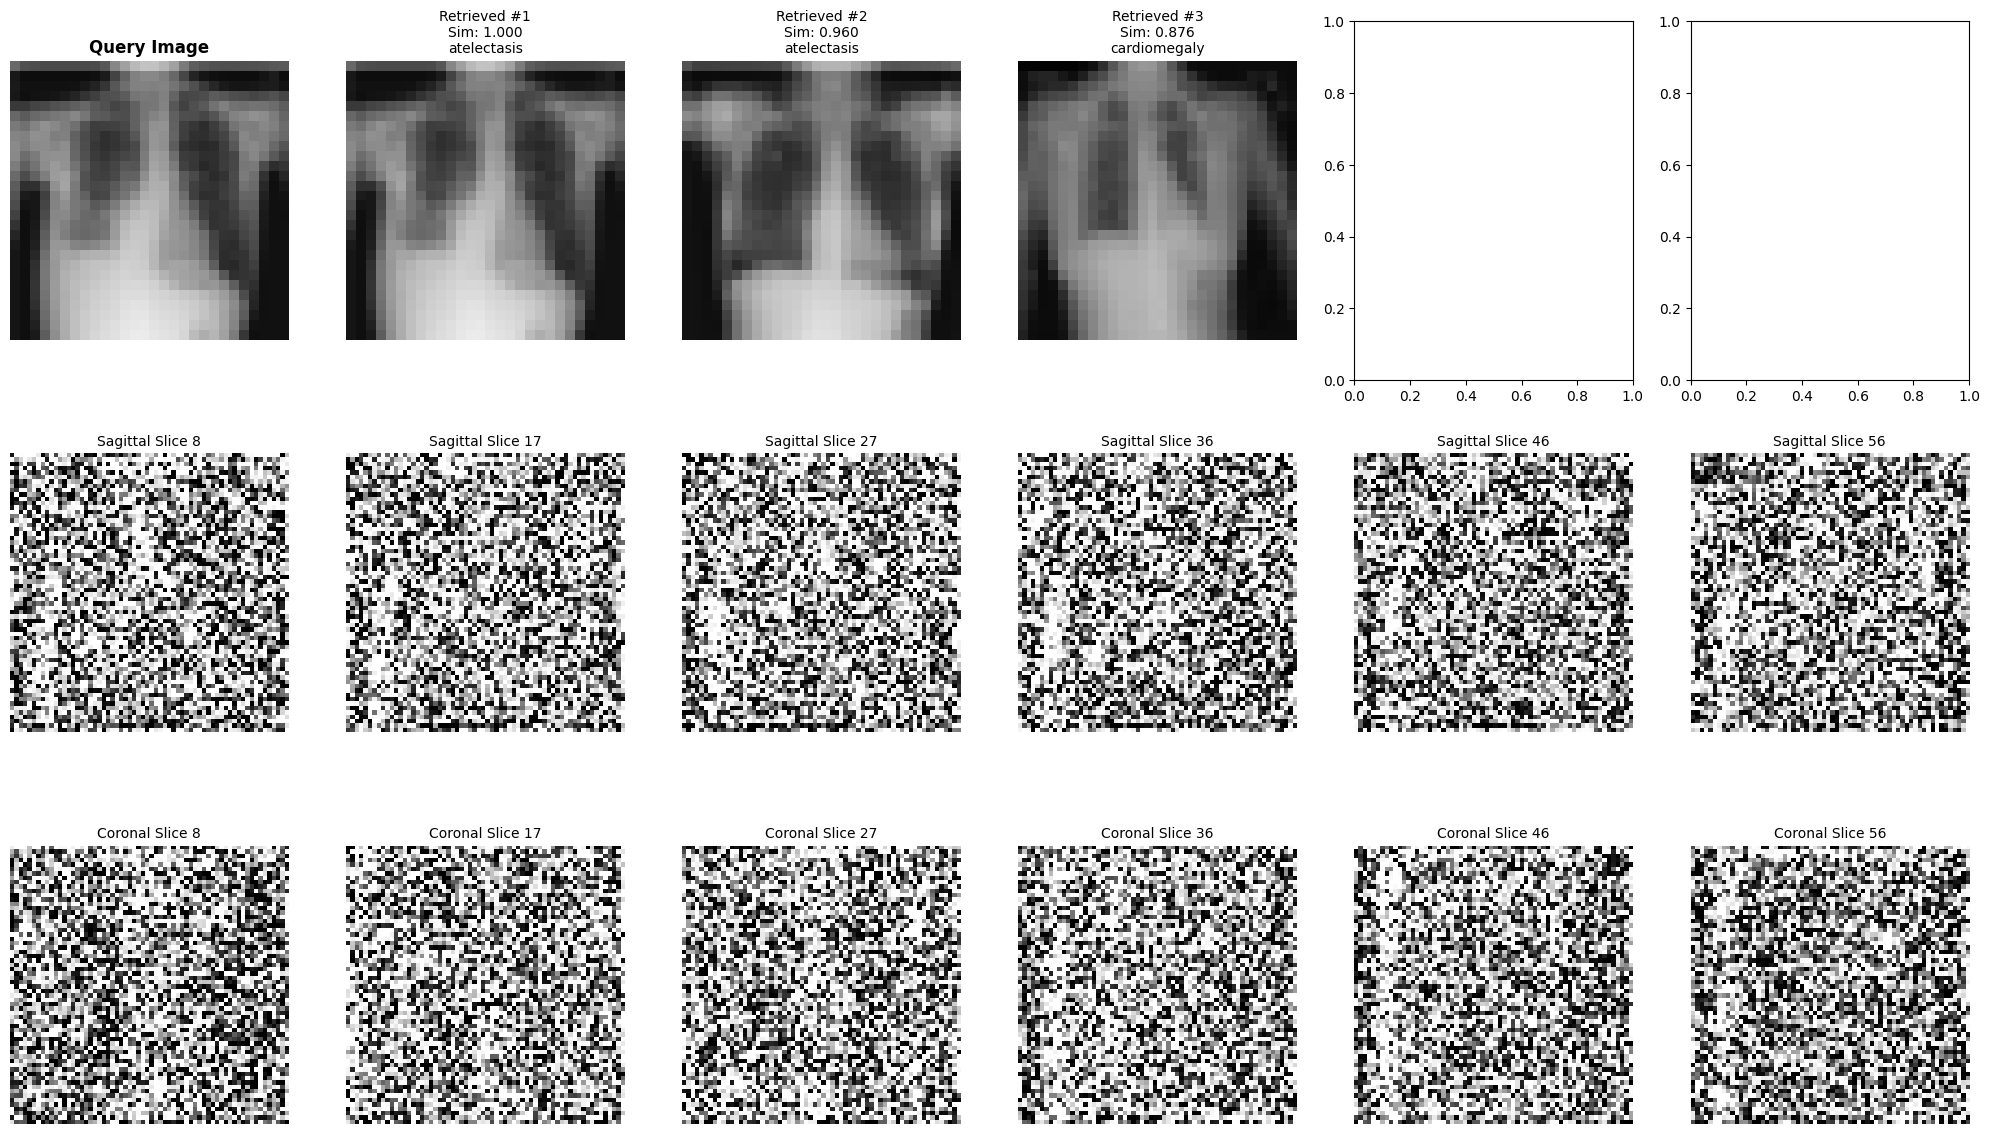

✅ Results saved to rag_diffusion_outputs/
💾 Datasets saved to medmnist_loaded/ (chestmnist.npz, organmnist3d.npz)


Saving download (1).jpeg to download (1) (1).jpeg
Processing external query: download (1) (1).jpeg


Generating 3D volume: 100%|██████████| 30/30 [01:50<00:00,  3.67s/it]


Visualizing top-5 retrieved images...


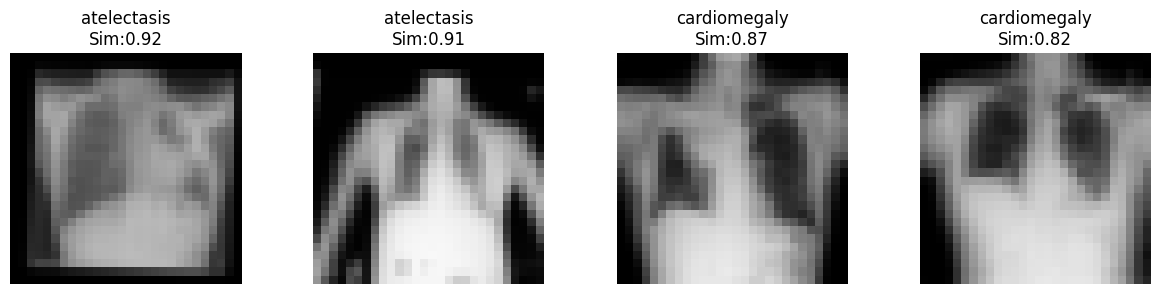

Rendering interactive 3D model...


{'predicted_label': np.int64(0),
 'query_embedding': array([[ 7.79407322e-01,  1.94372069e-02,  8.45186353e-01,
          8.79645944e-01,  7.04591751e-01,  3.70555311e-01,
         -7.95794904e-01, -8.72003473e-03,  2.95754266e+00,
          1.26925766e+00,  2.02836227e+00, -1.19103575e+00,
          1.31722152e+00, -1.51378441e+00,  1.12212110e+00,
          5.52414834e-01,  1.29202461e+00, -1.89986765e-01,
          2.84312308e-01, -1.10431027e+00,  1.50142144e-02,
          7.88107812e-01, -1.61919034e+00,  2.32873631e+00,
          5.58745503e-01,  1.17819242e-01,  9.47291374e-01,
          1.28791034e+00,  6.13910072e-02,  1.43909860e+00,
         -8.08648288e-01, -9.56922352e-01,  4.53018844e-01,
         -5.18948615e-01, -6.06642306e-01, -1.47381318e+00,
         -9.96170461e-01,  2.03366470e+00,  3.98658365e-01,
         -1.66136825e+00,  2.15495133e+00,  1.46233344e+00,
         -5.34345686e-01, -2.60342431e+00,  1.07927525e+00,
          6.07893169e-01,  1.33563805e+00, -1.45

In [ ]:
pipeline, results = run_complete_demo()
pipeline.save_datasets()
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
pipeline.run_external_query(img_path)


# New Section

Processing external query: download (1).jpeg


Generating 3D volume: 100%|██████████| 30/30 [01:53<00:00,  3.77s/it]


Visualizing top-5 retrieved images...


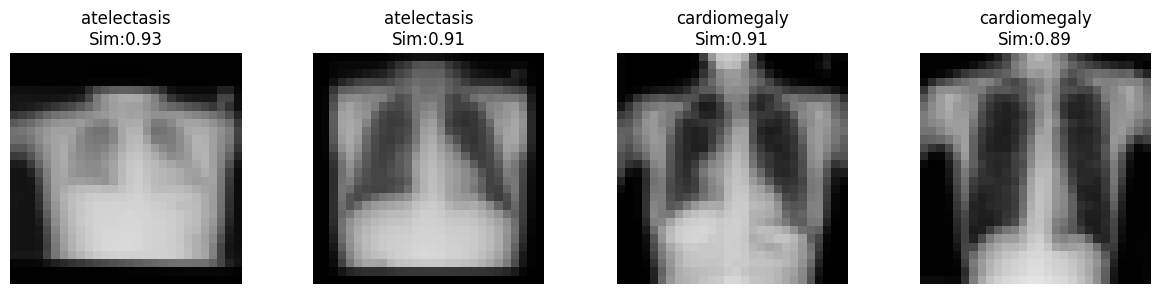

Rendering interactive 3D model...


{'predicted_label': np.int64(0),
 'query_embedding': array([[ 7.79407322e-01,  1.94372069e-02,  8.45186353e-01,
          8.79645944e-01,  7.04591751e-01,  3.70555311e-01,
         -7.95794904e-01, -8.72003473e-03,  2.95754266e+00,
          1.26925766e+00,  2.02836227e+00, -1.19103575e+00,
          1.31722152e+00, -1.51378441e+00,  1.12212110e+00,
          5.52414834e-01,  1.29202461e+00, -1.89986765e-01,
          2.84312308e-01, -1.10431027e+00,  1.50142144e-02,
          7.88107812e-01, -1.61919034e+00,  2.32873631e+00,
          5.58745503e-01,  1.17819242e-01,  9.47291374e-01,
          1.28791034e+00,  6.13910072e-02,  1.43909860e+00,
         -8.08648288e-01, -9.56922352e-01,  4.53018844e-01,
         -5.18948615e-01, -6.06642306e-01, -1.47381318e+00,
         -9.96170461e-01,  2.03366470e+00,  3.98658365e-01,
         -1.66136825e+00,  2.15495133e+00,  1.46233344e+00,
         -5.34345686e-01, -2.60342431e+00,  1.07927525e+00,
          6.07893169e-01,  1.33563805e+00, -1.45

In [ ]:
pipeline.run_external_query(img_path)
